# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [253]:
# Carregando a base de dados

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [254]:
#Verificando valores faltantes
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

- Na base de dados só existe valores faltantes na variavel **tempo_emprego** 

In [255]:
#df.fillna(df['tempo_emprego'].std(),inplace=True)
df.dropna(inplace=True)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.

In [256]:
#Separando os dados *out of time*
oot=df[df['data_ref']> '2015-12-01']
data=df[df['data_ref']<= '2015-12-01']
data

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599993,2015-12-01,5411,M,S,S,0,Assalariado,Médio,Casado,Casa,36,18.189041,2.0,34984.95,False
599994,2015-12-01,5350,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,46,13.104110,1.0,28604.39,False
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [257]:
data.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [258]:
def quantitativa(data,var):
    
    return plt.hist(data[var])
    

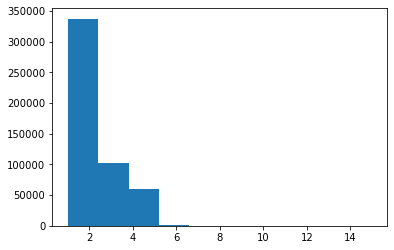

In [273]:
quantitativa(data,'qt_pessoas_residencia');

- Majoritariamente as residencias dos clientes possuem até 2 moradores.

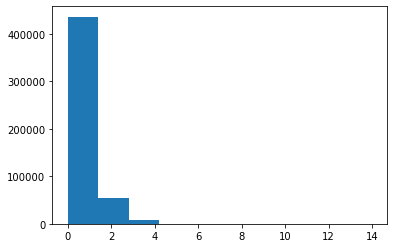

In [260]:
quantitativa(data,'qtd_filhos');

- A maioria dos clientes possuem somente um filho;

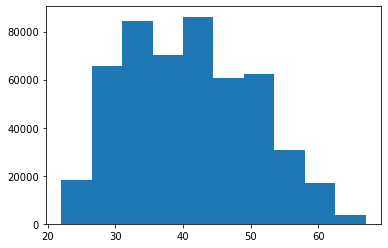

In [261]:
quantitativa(data,'idade');

- Há um distribuição quase simetrica na idade dos clientes

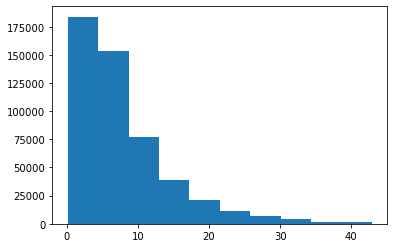

In [262]:
quantitativa(data,'tempo_emprego');

- O tempo de emprego possui um distribuição assimetrica a direita.

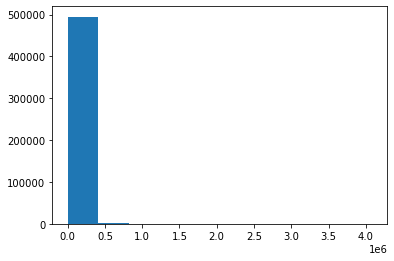

In [263]:
quantitativa(data,'renda');

- O tempo de emprego possui um distribuição assimetrica a direita.

In [264]:
def qualitativa(data,var):
    
    return sns.countplot(x=data[var])
    

<AxesSubplot:xlabel='sexo', ylabel='count'>

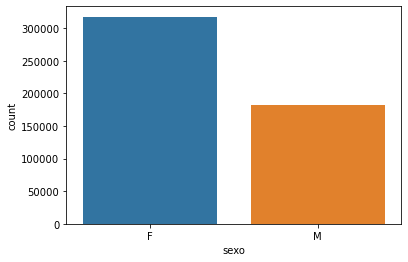

In [265]:
qualitativa(data,'sexo')

- O publica feminino representa a maior parte dos clientes na base de dados

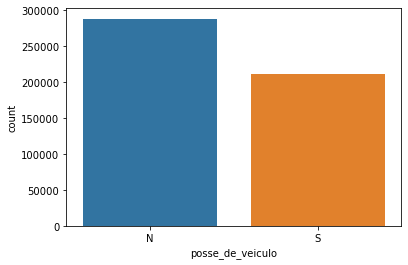

In [266]:
qualitativa(data,'posse_de_veiculo');

- A maioria dos clientes não possue veiculos 

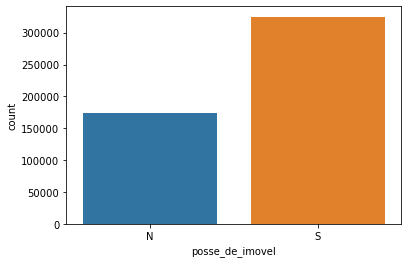

In [267]:
qualitativa(data,'posse_de_imovel');

- A maioria dos clientes possuem imovel

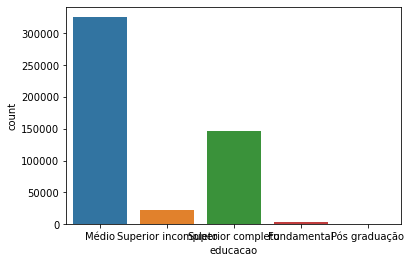

In [268]:
qualitativa(data,'educacao');

- O ensino médio representa a maior parte dos clientes na variavel educação

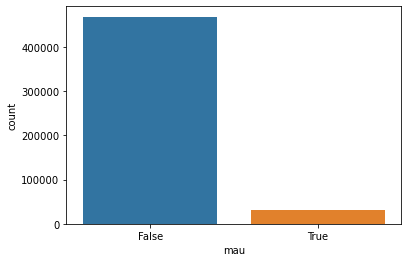

In [269]:
qualitativa(data,'mau');

- Os maus clientes representam a menor parte na nossa base de dados

<AxesSubplot:xlabel='estado_civil', ylabel='count'>

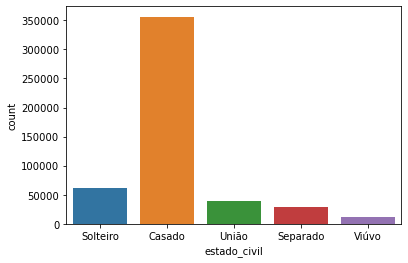

In [270]:
qualitativa(data,'estado_civil')

- Casado é o estado civil da marioria dos clientes

<AxesSubplot:xlabel='tipo_renda', ylabel='count'>

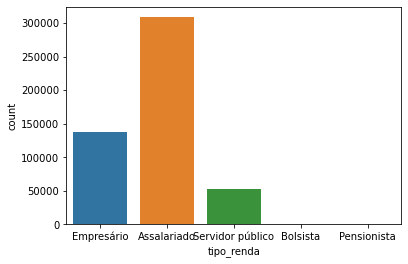

In [271]:
qualitativa(data,'tipo_renda')

- Assalariado é o maior tipo de renda dos clientes

<AxesSubplot:xlabel='tipo_residencia', ylabel='count'>

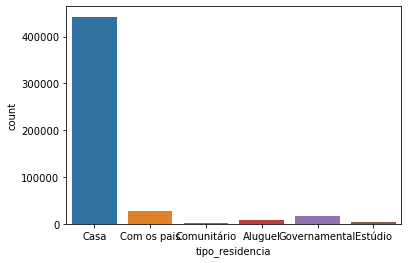

In [272]:
qualitativa(data,'tipo_residencia')

- Casa representa a maior parte dos clientes em tipos residencia

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [200]:
amostragem=data.sample(n=2000)

In [90]:
def biv_discreta(var, data):
    data['bom'] = 1-data.mau
    g = amostragem.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = amostragem.mau.mean()
    woe_geral = np.log(amostragem.mau.mean() / (1 - amostragem.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:g', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

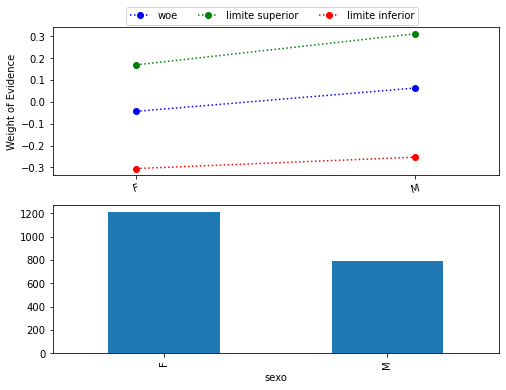

In [91]:
biv_discreta('sexo',amostragem);

- A variável não discrimina muito uma vez que os grupos M(masculino) e F(feminino) estão bem parecidos no intervalo de confiança.

C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


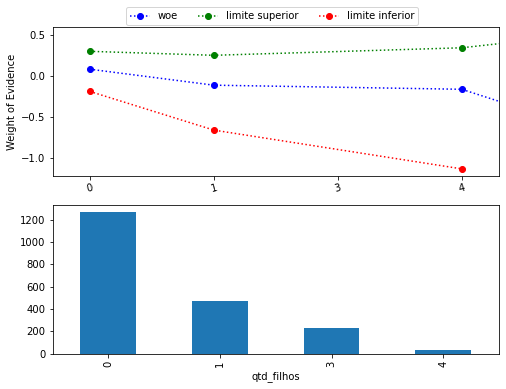

In [88]:
biv_discreta('qtd_filhos',amostragem);

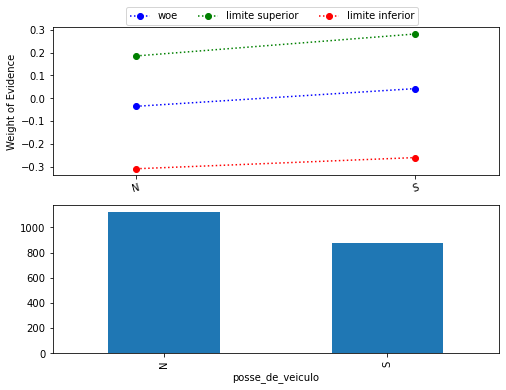

In [92]:
biv_discreta('posse_de_veiculo',amostragem);

- A variável tem não discrimina de uma forma marcante

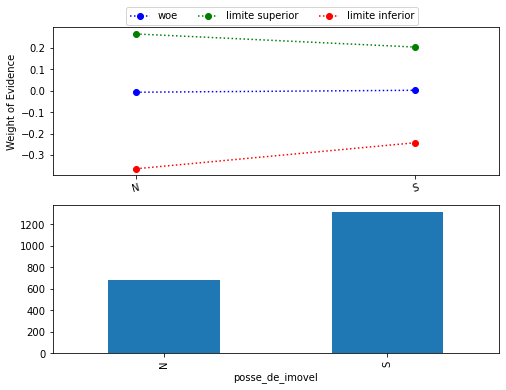

In [93]:
biv_discreta('posse_de_imovel',amostragem);

- A variável tem não discrimina de uma forma marcante

C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


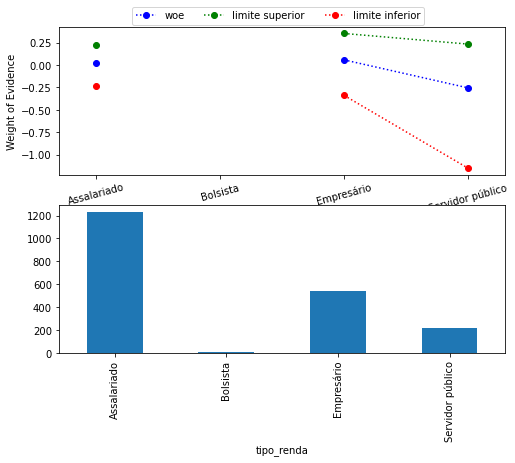

In [94]:
biv_discreta('tipo_renda',amostragem);

- Aqui é possível verificar que existe alguns zeros estruturais que podemos tratar agrupando algumas categorias

C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


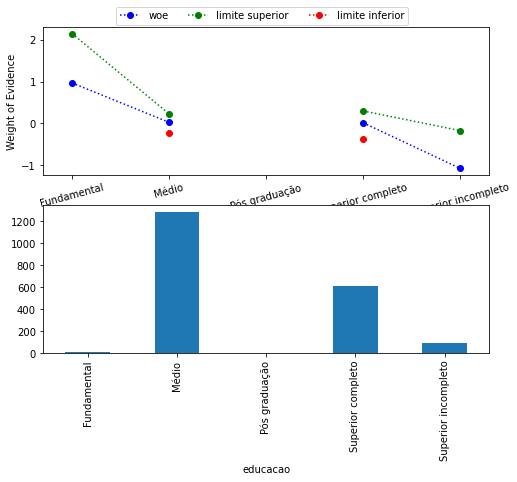

In [95]:
biv_discreta('educacao',amostragem);

- Aqui é possível verificar que existe alguns zeros estruturais que podemos tratar agrupando algumas categorias

C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


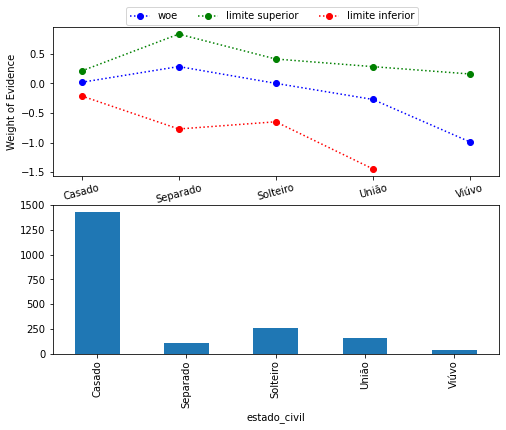

In [96]:
biv_discreta('estado_civil',amostragem);

- Aqui é possível verificar que existe alguns zeros estruturais que podemos tratar agrupando algumas categorias

C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


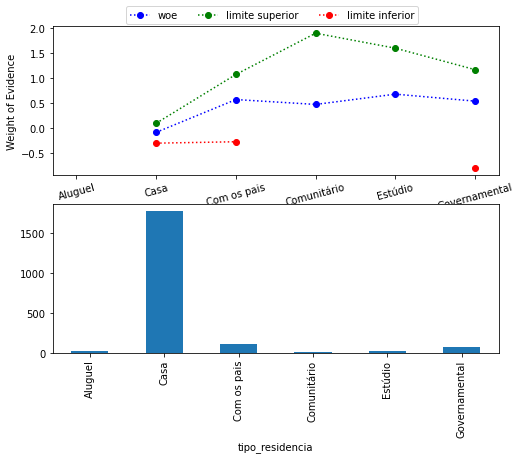

In [97]:
biv_discreta('tipo_residencia',amostragem);

- Aqui é possível verificar que existe alguns zeros estruturais que podemos tratar agrupando algumas categorias

In [18]:
metadados=pd.DataFrame(data.dtypes,columns=['dtypes'])
metadados['missing']=data.isna().sum()
metadados['valores_unicos']=data.nunique()
metadados

,dtypes,missing,valores_unicos
data_ref,datetime64[ns],0,12
index,int64,0,13857
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [8]:
data['mau']=data.mau.astype('int64')

C:\Users\General\AppData\Local\Temp\ipykernel_6864\1644639960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mau']=data.mau.astype('int64')


In [9]:
data.mau.value_counts()

0    468960
1     30165
Name: mau, dtype: int64

In [10]:
data_amostra=pd.concat([data[data.mau==1].sample(n=1000),data[data.mau==0].sample(n=1000)])
tab_am=data_amostra.mau.value_counts()
tab_am

1    1000
0    1000
Name: mau, dtype: int64

In [11]:
tab_pop=data.mau.value_counts()
tab_pop

0    468960
1     30165
Name: mau, dtype: int64

In [12]:
rho_mau=tab_am.loc[1]/tab_am.sum()
rho_bom=tab_am.loc[0]/tab_am.sum()

pi_mau=tab_pop.loc[1]/tab_pop.sum()
pi_bom=tab_pop.loc[0]/tab_pop.sum()

wbom=pi_bom*rho_bom
wmau=pi_mau*rho_mau


print(f'wbom= {wbom},wmau= {wmau}')

wbom= 0.46978211870773856,wmau= 0.030217881292261457


In [13]:
data_amostra.loc[data_amostra.mau==1,'w']=wmau
data_amostra.loc[data_amostra.mau==0,'w']=wbom
data_amostra.groupby('mau')['w'].sum()/data_amostra.w.sum()

mau
0    0.939564
1    0.060436
Name: w, dtype: float64

In [14]:
def IV(variavel,resposta):
    tab=pd.crosstab(variavel,resposta,margins=True,margins_name='total')
    
    rotulo_evento=tab.columns[0]
    rotulo_nao_evento=tab.columns[1]
    
    tab['pct_evento']=tab[rotulo_evento]/tab.loc['total',rotulo_evento]
    tab['ep']=tab[rotulo_evento]/tab.loc['total',rotulo_evento]
    
    tab['pct_nao_evento']=tab[rotulo_nao_evento]/tab.loc['total',rotulo_nao_evento]
    tab['woe']=np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial']=(tab.pct_evento-tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()


In [16]:
IV(data.sexo,data.mau)

0.002514770276738207

In [19]:
metadados['papel']='covariavel'
metadados.loc['mau','papel']='resposta'
metadados


,dtypes,missing,valores_unicos,papel
data_ref,datetime64[ns],0,12,covariavel
index,int64,0,13857,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel


In [20]:
for var in metadados[metadados.papel=='covariavel'].index:
    if (metadados.loc[var,'valores_unicos']>6):
        metadados.loc[var,'IV']=IV(pd.qcut(data[var],q=5,duplicates='drop'),data.mau)
    else:
        metadados.loc[var,'IV']=IV(data[var],data.mau)
        
metadados

,dtypes,missing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,12,covariavel,0.242563
index,int64,0,13857,covariavel,0.003312
sexo,object,0,2,covariavel,0.002515
posse_de_veiculo,object,0,2,covariavel,0.000036
posse_de_imovel,object,0,2,covariavel,0.011301
qtd_filhos,int64,0,8,covariavel,0.000138
tipo_renda,object,0,5,covariavel,0.011082
educacao,object,0,5,covariavel,0.003819
estado_civil,object,0,5,covariavel,0.002406
tipo_residencia,object,0,6,covariavel,0.004550


In [34]:
def biv_continua(var, ncat, data):
    data['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = data.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = data.mau.mean()
    woe_geral = np.log(data.mau.mean() / (1 - data.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:g', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\General\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


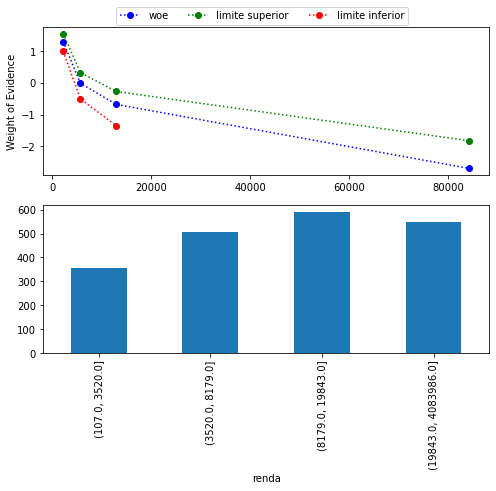

In [36]:
biv_continua('renda',4,amostragem);

- Quanto maior a renda, menor o risco de se tornar um mau cliente 

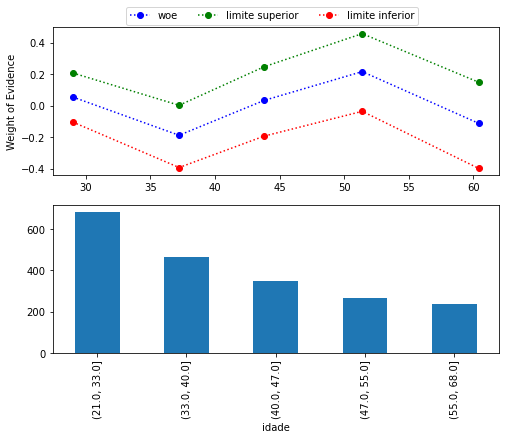

In [370]:
biv_continua('idade',5,amostragem);

- O risco de ser tornar um mau pagador é entre 45 a 52 anos

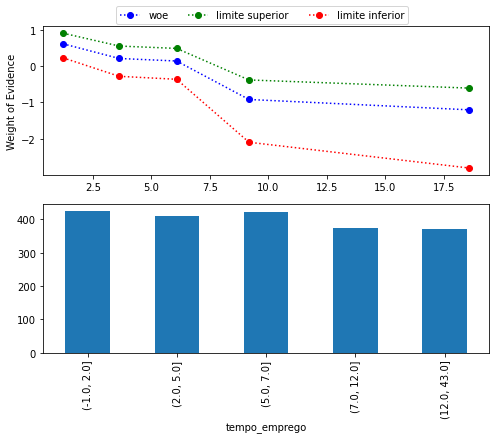

In [37]:
biv_continua('tempo_emprego',5,amostragem);

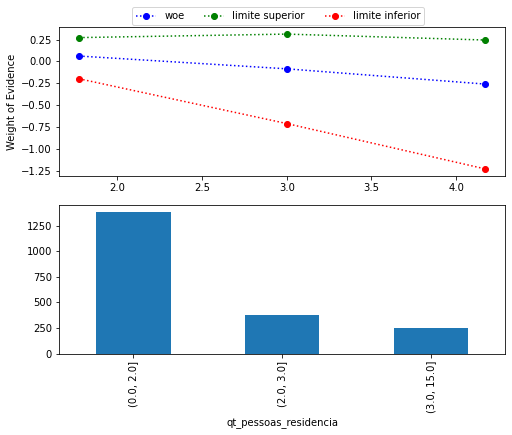

In [38]:
biv_continua('qt_pessoas_residencia',5,amostragem);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratanto outliers

- Abaixo estou definindo um função para substituir os outliers pela valor minimo naquela variável

In [215]:
def substituir_outliers(var,data):
    q1=np.percentile(data[var],25)
    q3=np.percentile(data[var],75)
    
    c=1.5
    intervalo=q3-q1
    limite_superior=q3+c*intervalo
    limite_inferior=q1-c*intervalo
    
    variavel_sem_outliers=[]
    variavel_com_outliers=[]
    for i in data[var]:
        if i > limite_superior or i < limite_inferior:
            variavel_com_outliers.append(i)
        else:
            variavel_sem_outliers.append(i)

    #media_sem_outliers=pd.DataFrame(variavel_sem_outliers).min()
    #print(pd.DataFrame(variavel_com_outliers).mean())
    media_sem_outliers=data[var].min()
    
    data[var].where((data[var]> limite_superior) & (data[var]<limite_inferior),
                                      media_sem_outliers)
    
    sns.boxplot(data[var])
    
    
    return 

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


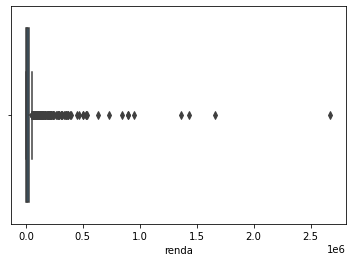

In [216]:
substituir_outliers('renda',amostragem);

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='renda'>

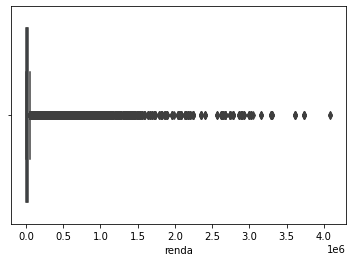

In [221]:
sns.boxplot(data['renda'])

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


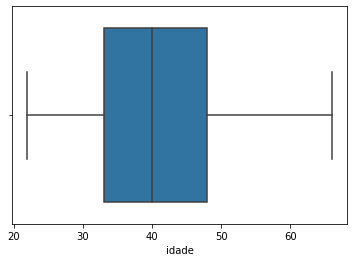

In [217]:
substituir_outliers('idade',amostragem);

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='idade'>

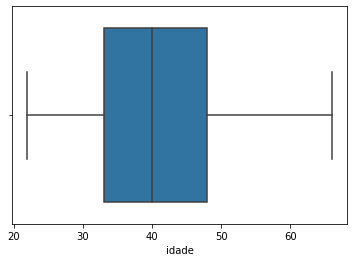

In [211]:
sns.boxplot(amostragem['idade'])

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


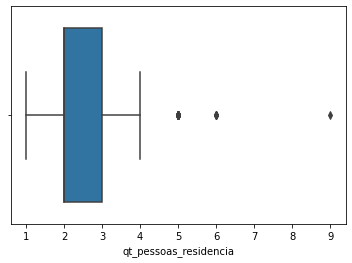

In [218]:
substituir_outliers('qt_pessoas_residencia',amostragem);

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


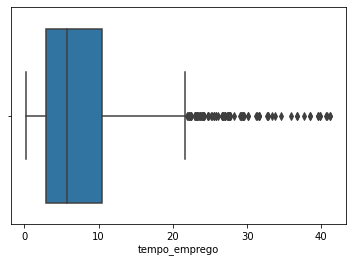

In [219]:
substituir_outliers('tempo_emprego',amostragem);

C:\Users\General\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


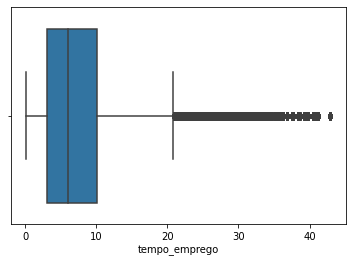

In [220]:
sns.boxplot(data['tempo_emprego']);

### Trantando zeros estruturais

In [224]:
amostragem['qtd_filhos'].replace({2:3,3:4,3:4,7:3,4:3},inplace=True)

In [225]:
amostragem['qtd_filhos'].value_counts()

0    1269
1     477
4     223
3      31
Name: qtd_filhos, dtype: int64

In [228]:
#Aqui vou separar com ensino superior e sem 
amostragem['educacao'].value_counts()

Médio                          1334
Pós graud/Superior completo     578
Sup Incompleto                   88
Name: educacao, dtype: int64

In [227]:
amostragem['educacao'].replace({'Pós graduação':'Pós graud/Superior completo','Superior completo':'Pós graud/Superior completo',
                                'Fundamental':'Sup Incompleto','Superior incompleto':'Sup Incompleto'},inplace=True)

In [231]:
amostragem['tipo_residencia'].value_counts()

Casa                                 1752
Aluguel/Com pais                      160
Comunitário/Governamental/Estudio      88
Name: tipo_residencia, dtype: int64

In [230]:
amostragem['tipo_residencia'].replace({'Aluguel':'Aluguel/Com pais','Com os pais':'Aluguel/Com pais',
                                       'Comunitário':'Comunitário/Governamental/Estudio','Governamental':'Comunitário/Governamental/Estudio','Estúdio':'Comunitário/Governamental/Estudio'},inplace=True)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [232]:
' + '.join(list(data.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [233]:
formula = ''' mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=amostragem, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:                 2000
Model:                                     GLM   Df Residuals:                     1979
Model Family:                         Binomial   Df Model:                           20
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -431.87
Date:                         sex, 14 jul 2023   Deviance:                       863.75
Time:                                 14:16:14   Pearson chi2:                 4.30e+03
No. Iterations:                             19   Pseudo R-squ. (CS):            0.05049
Covariance Type:                     nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                0.2457      0.930      0.264      0.792      -1.577       2.068
sexo[T.M]                                                0.0118      0.203      0.058      0.954      -0.387       0.410
posse_de_veiculo[T.S]                                   -0.0302      0.200     -0.151      0.880      -0.423       0.362
posse_de_imovel[T.S]                                    -0.1333      0.201     -0.664      0.507      -0.527       0.260
tipo_renda[T.Bolsista]                                  17.3745   1.24e+04      0.001      0.999   -2.44e+04    2.44e+04
tipo_renda[T.Empresário]                                 0.0187      0.214      0.087      0.931      -0.401       0.438
tipo_renda[T.Pensionista]                               -2.2545      1.451     -1.554      0.120      -5.098       0.589
tipo_renda[T.Servidor público]                           0.0672      0.375      0.179      0.858      -0.668       0.802
educacao[T.Pós graud/Superior completo]                  0.3411      0.227      1.503      0.133      -0.104       0.786
educacao[T.Sup Incompleto]                              -0.1299      0.403     -0.322      0.747      -0.919       0.660
estado_civil[T.Separado]                                 0.5712      0.548      1.042      0.298      -0.504       1.646
estado_civil[T.Solteiro]                                 0.1985      0.452      0.439      0.661      -0.688       1.085
estado_civil[T.União]                                    0.0808      0.377      0.215      0.830      -0.657       0.819
estado_civil[T.Viúvo]                                    0.5875      0.838      0.701      0.483      -1.056       2.231
tipo_residencia[T.Casa]                                 -0.2845      0.333     -0.854      0.393      -0.938       0.369
tipo_residencia[T.Comunitário/Governamental/Estudio]    -0.0338      0.614     -0.055      0.956      -1.236       1.169
qtd_filhos                                              -0.2541      0.195     -1.304      0.192      -0.636       0.128
idade                                                    0.0160      0.011      1.431      0.152      -0.006       0.038
tempo_emprego                                            0.0639      0.030      2.156      0.031       0.006       0.122
qt_pessoas_residencia                                    0.4512      0.344      1.311      0.190      -0.223       1.126
renda                                                 7.455e-05   1.62e-05      4.589      0.000    4.27e-05       0.000
================================================================================

In [235]:
amostragem['score'] = rl.predict(amostragem)

# Acurácia
acc = metrics.accuracy_score(amostragem.mau, amostragem.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(amostragem.mau, amostragem.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(amostragem.loc[amostragem.mau == 1, 'score'], amostragem.loc[amostragem.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 6.6% 
AUC: 23.3% 
GINI: -53.3%
KS: 41.3%


In [201]:
metadados.sort_values(by='IV',ascending=False).head().index

Index(['renda', 'data_ref', 'estado_civil', 'idade', 'tipo_renda'], dtype='object')

In [236]:
formula = ''' C(mau) ~ renda + tempo_emprego + idade
'''

rl = smf.glm(formula, data=amostragem, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Generalized Linear Model Regression Results                         
=============================================================================================
Dep. Variable:     ['C(mau)[False]', 'C(mau)[True]']   No. Observations:                 2000
Model:                                           GLM   Df Residuals:                     1996
Model Family:                               Binomial   Df Model:                            3
Link Function:                                 Logit   Scale:                          1.0000
Method:                                         IRLS   Log-Likelihood:                -436.61
Date:                               sex, 14 jul 2023   Deviance:                       873.23
Time:                                       14:17:04   Pearson chi2:                 4.71e+03
No. Iterations:                                   10   Pseudo R-squ. (CS):            0.04598
Covariance Type:                           nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0348      0.402      2.573      0.010       0.247       1.823
renda          7.452e-05    1.6e-05      4.657      0.000    4.32e-05       0.000
tempo_emprego     0.0639      0.029      2.203      0.028       0.007       0.121
idade             0.0129      0.010      1.274      0.203      -0.007       0.033
=================================================================================
"""

In [237]:
amostragem['score'] = rl.predict(amostragem)

# Acurácia
acc = metrics.accuracy_score(amostragem.mau, amostragem.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(amostragem.mau, amostragem.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(amostragem.loc[amostragem.mau == 1, 'score'], amostragem.loc[amostragem.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 6.6% 
AUC: 23.4% 
GINI: -53.1%
KS: 41.8%
